# 05a - Amazon Customer Reviews - processing

In [1]:
# Start a Spark application and print the version
spark.version

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
3,application_1592828203559_0004,pyspark,idle,Link,Link,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

'2.4.5-amzn-0'

In [2]:
def run_query(query, show=True):
    """
    Custom function to run spark.sql. Default will submit the query and show the result.
    """
    if show:
        return spark.sql(query).show()
    else:
        return spark.sql(query)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## Check our Glue data catalogue

By having a persistent metastore outside of the EMR cluster, we can access the database and tables from different places such as:
* Other EMR clusters
* Athena
* Redshift
* Glue

In [3]:
run_query('show databases')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+
|        databaseName|
+--------------------+
|             default|
|             nyctaxi|
|             reviews|
|            sampledb|
|sessions_clickstr...|
|          tpc-ds-1tb|
|               tpcds|
|       tpcds-parquet|
+--------------------+

In [ ]:
run_query('use reviews')

In [5]:
run_query('show tables')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------+---------+-----------+
|database|tableName|isTemporary|
+--------+---------+-----------+
| reviews|      tsv|      false|
+--------+---------+-----------+

In [6]:
run_query('select * from tsv limit 5')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----------+-----------+--------------+----------+--------------+--------------------+----------------+-----------+-------------+-----------+----+-----------------+--------------------+--------------------+-----------+-----+-----+-----+-----+-----+-----+-----+-----+
|marketplace|customer_id|     review_id|product_id|product_parent|       product_title|product_category|star_rating|helpful_votes|total_votes|vine|verified_purchase|     review_headline|         review_body|review_date|col15|col16|col17|col18|col19|col20|col21|col22|
+-----------+-----------+--------------+----------+--------------+--------------------+----------------+-----------+-------------+-----------+----+-----------------+--------------------+--------------------+-----------+-----+-----+-----+-----+-----+-----+-----+-----+
|marketplace|customer_id|     review_id|product_id|          null|       product_title|product_category|star_rating|helpful_votes|total_votes|vine|verified_purchase|     review_headline|         r

## Prepare a Spark dataframe

In [ ]:
# US marketplace only to avoid non-US character

df = run_query('''
SELECT
  marketplace, 
  customer_id, 
  review_id, 
  product_id, 
  product_parent, 
  product_title, 
  product_category,
  CAST(star_rating as INT) star_rating, 
  CAST(helpful_votes as INT) helpful_votes, 
  CAST(total_votes as INT) total_votes, 
  vine, 
  verified_purchase, 
  review_headline, 
  review_body, 
  CAST(review_date as DATE) review_date
FROM reviews.tsv
WHERE marketplace='US'
''', show=False)

In [8]:
df.printSchema()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- marketplace: string (nullable = true)
 |-- customer_id: string (nullable = true)
 |-- review_id: string (nullable = true)
 |-- product_id: string (nullable = true)
 |-- product_parent: long (nullable = true)
 |-- product_title: string (nullable = true)
 |-- product_category: string (nullable = true)
 |-- star_rating: integer (nullable = true)
 |-- helpful_votes: integer (nullable = true)
 |-- total_votes: integer (nullable = true)
 |-- vine: string (nullable = true)
 |-- verified_purchase: string (nullable = true)
 |-- review_headline: string (nullable = true)
 |-- review_body: string (nullable = true)
 |-- review_date: date (nullable = true)

In [9]:
# variables
partitions=['product_category']
s3_bucket='s3://data.set.corvus'  # change to your bucket name; without trailing slash

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## Data conversion

* Partition by product category
* Convert to gzipped parquet
* Write to S3 (curated bucket)

<font color=red>This process will take 15 minutes on the provisioned auto-scaling cluster</font>

In [ ]:
df.repartition(*partitions)\
    .write.mode("OVERWRITE")\
    .partitionBy(partitions)\
    .parquet(f'{s3_bucket}/reviews/us/', compression='gzip')

While the task is running, explore the YARN timeline and Spark history server, which can be accessed from the EMR console

![emr-sparkui.png](images/emr-sparkui.png)

![spark-dag.png](images/spark-dag.png)
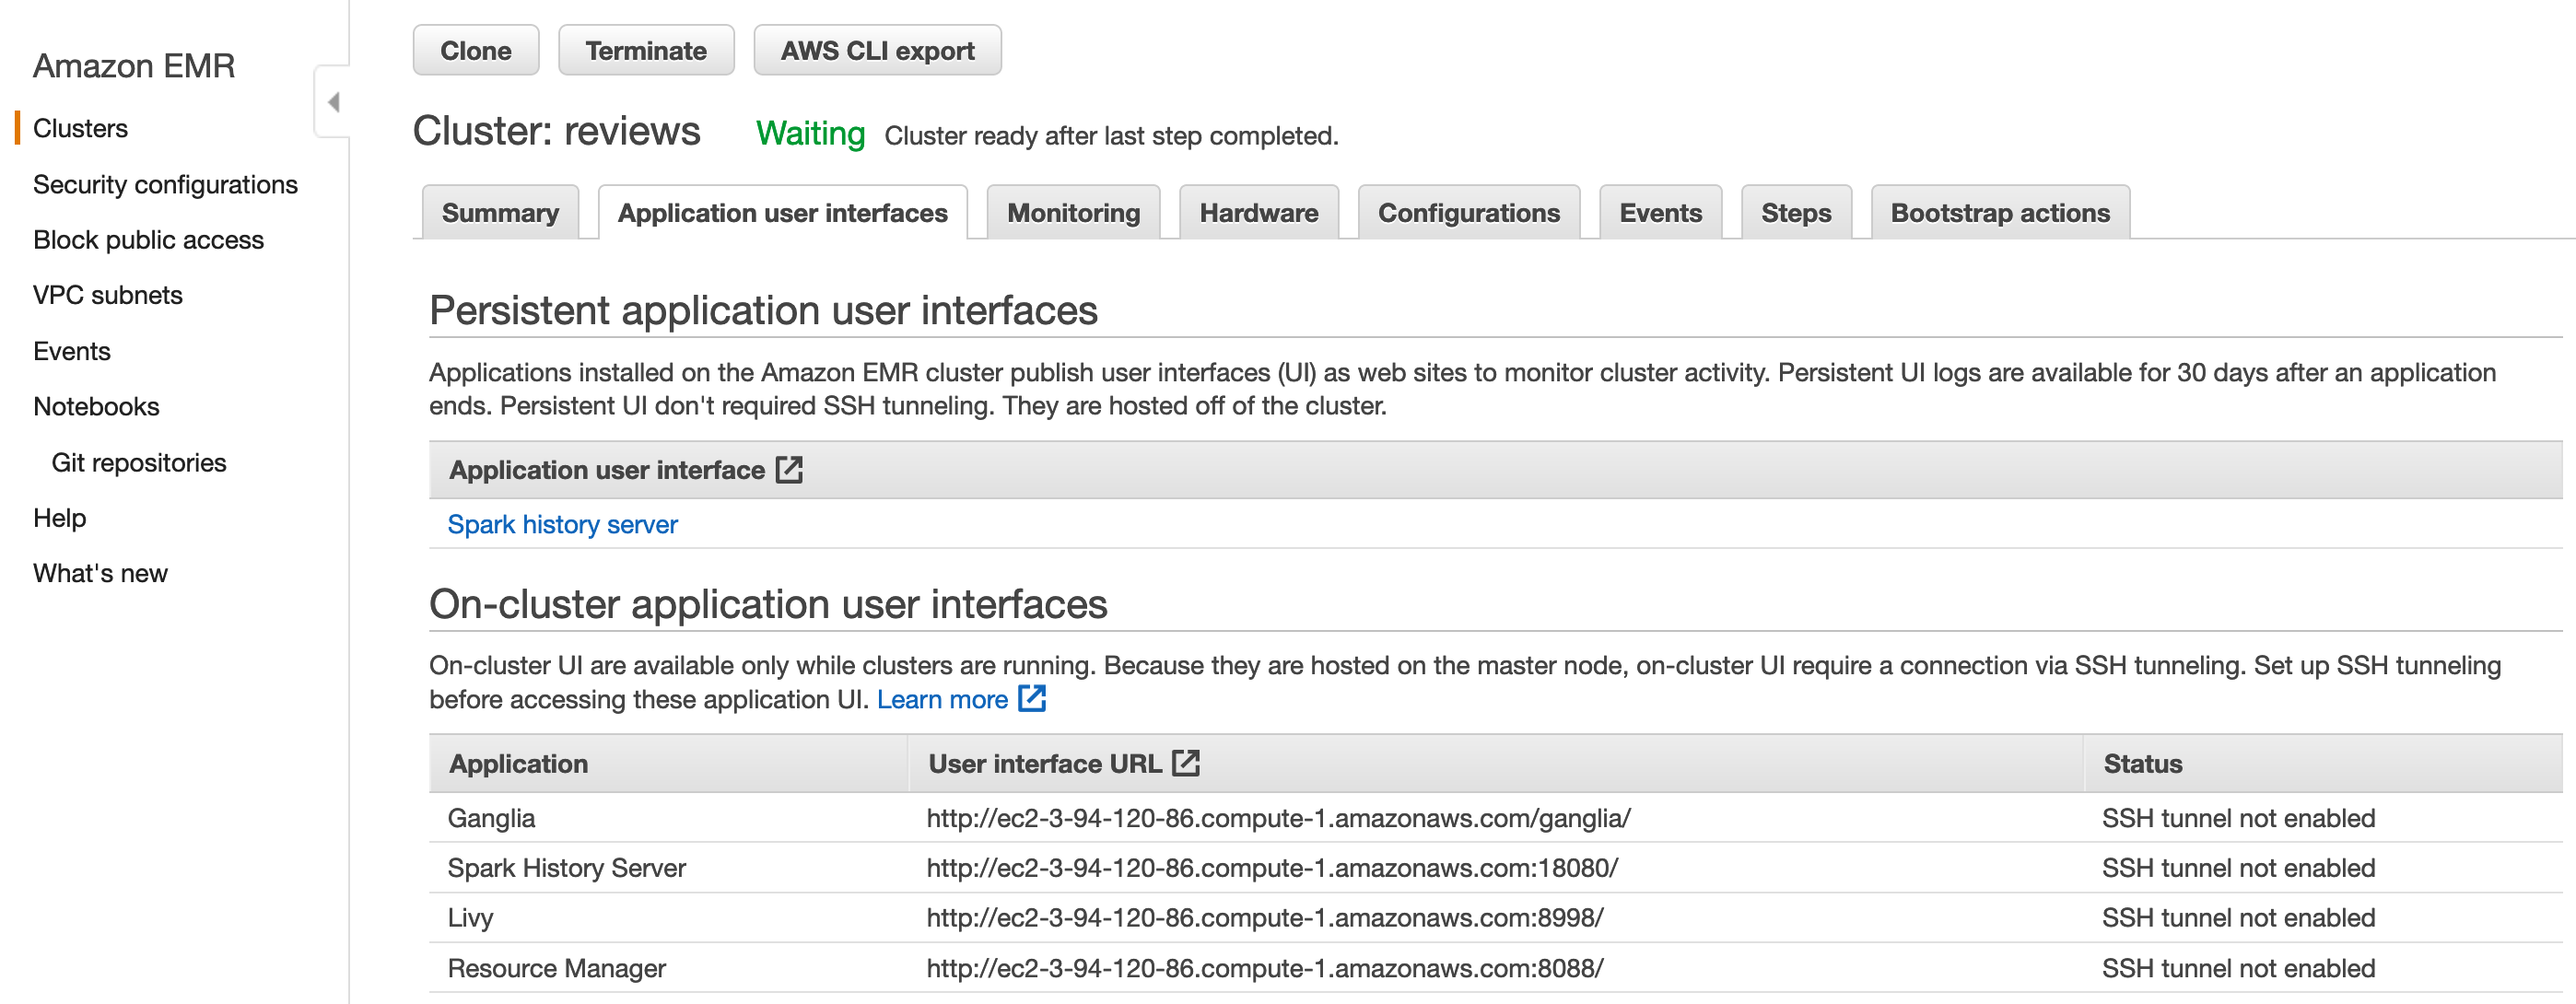
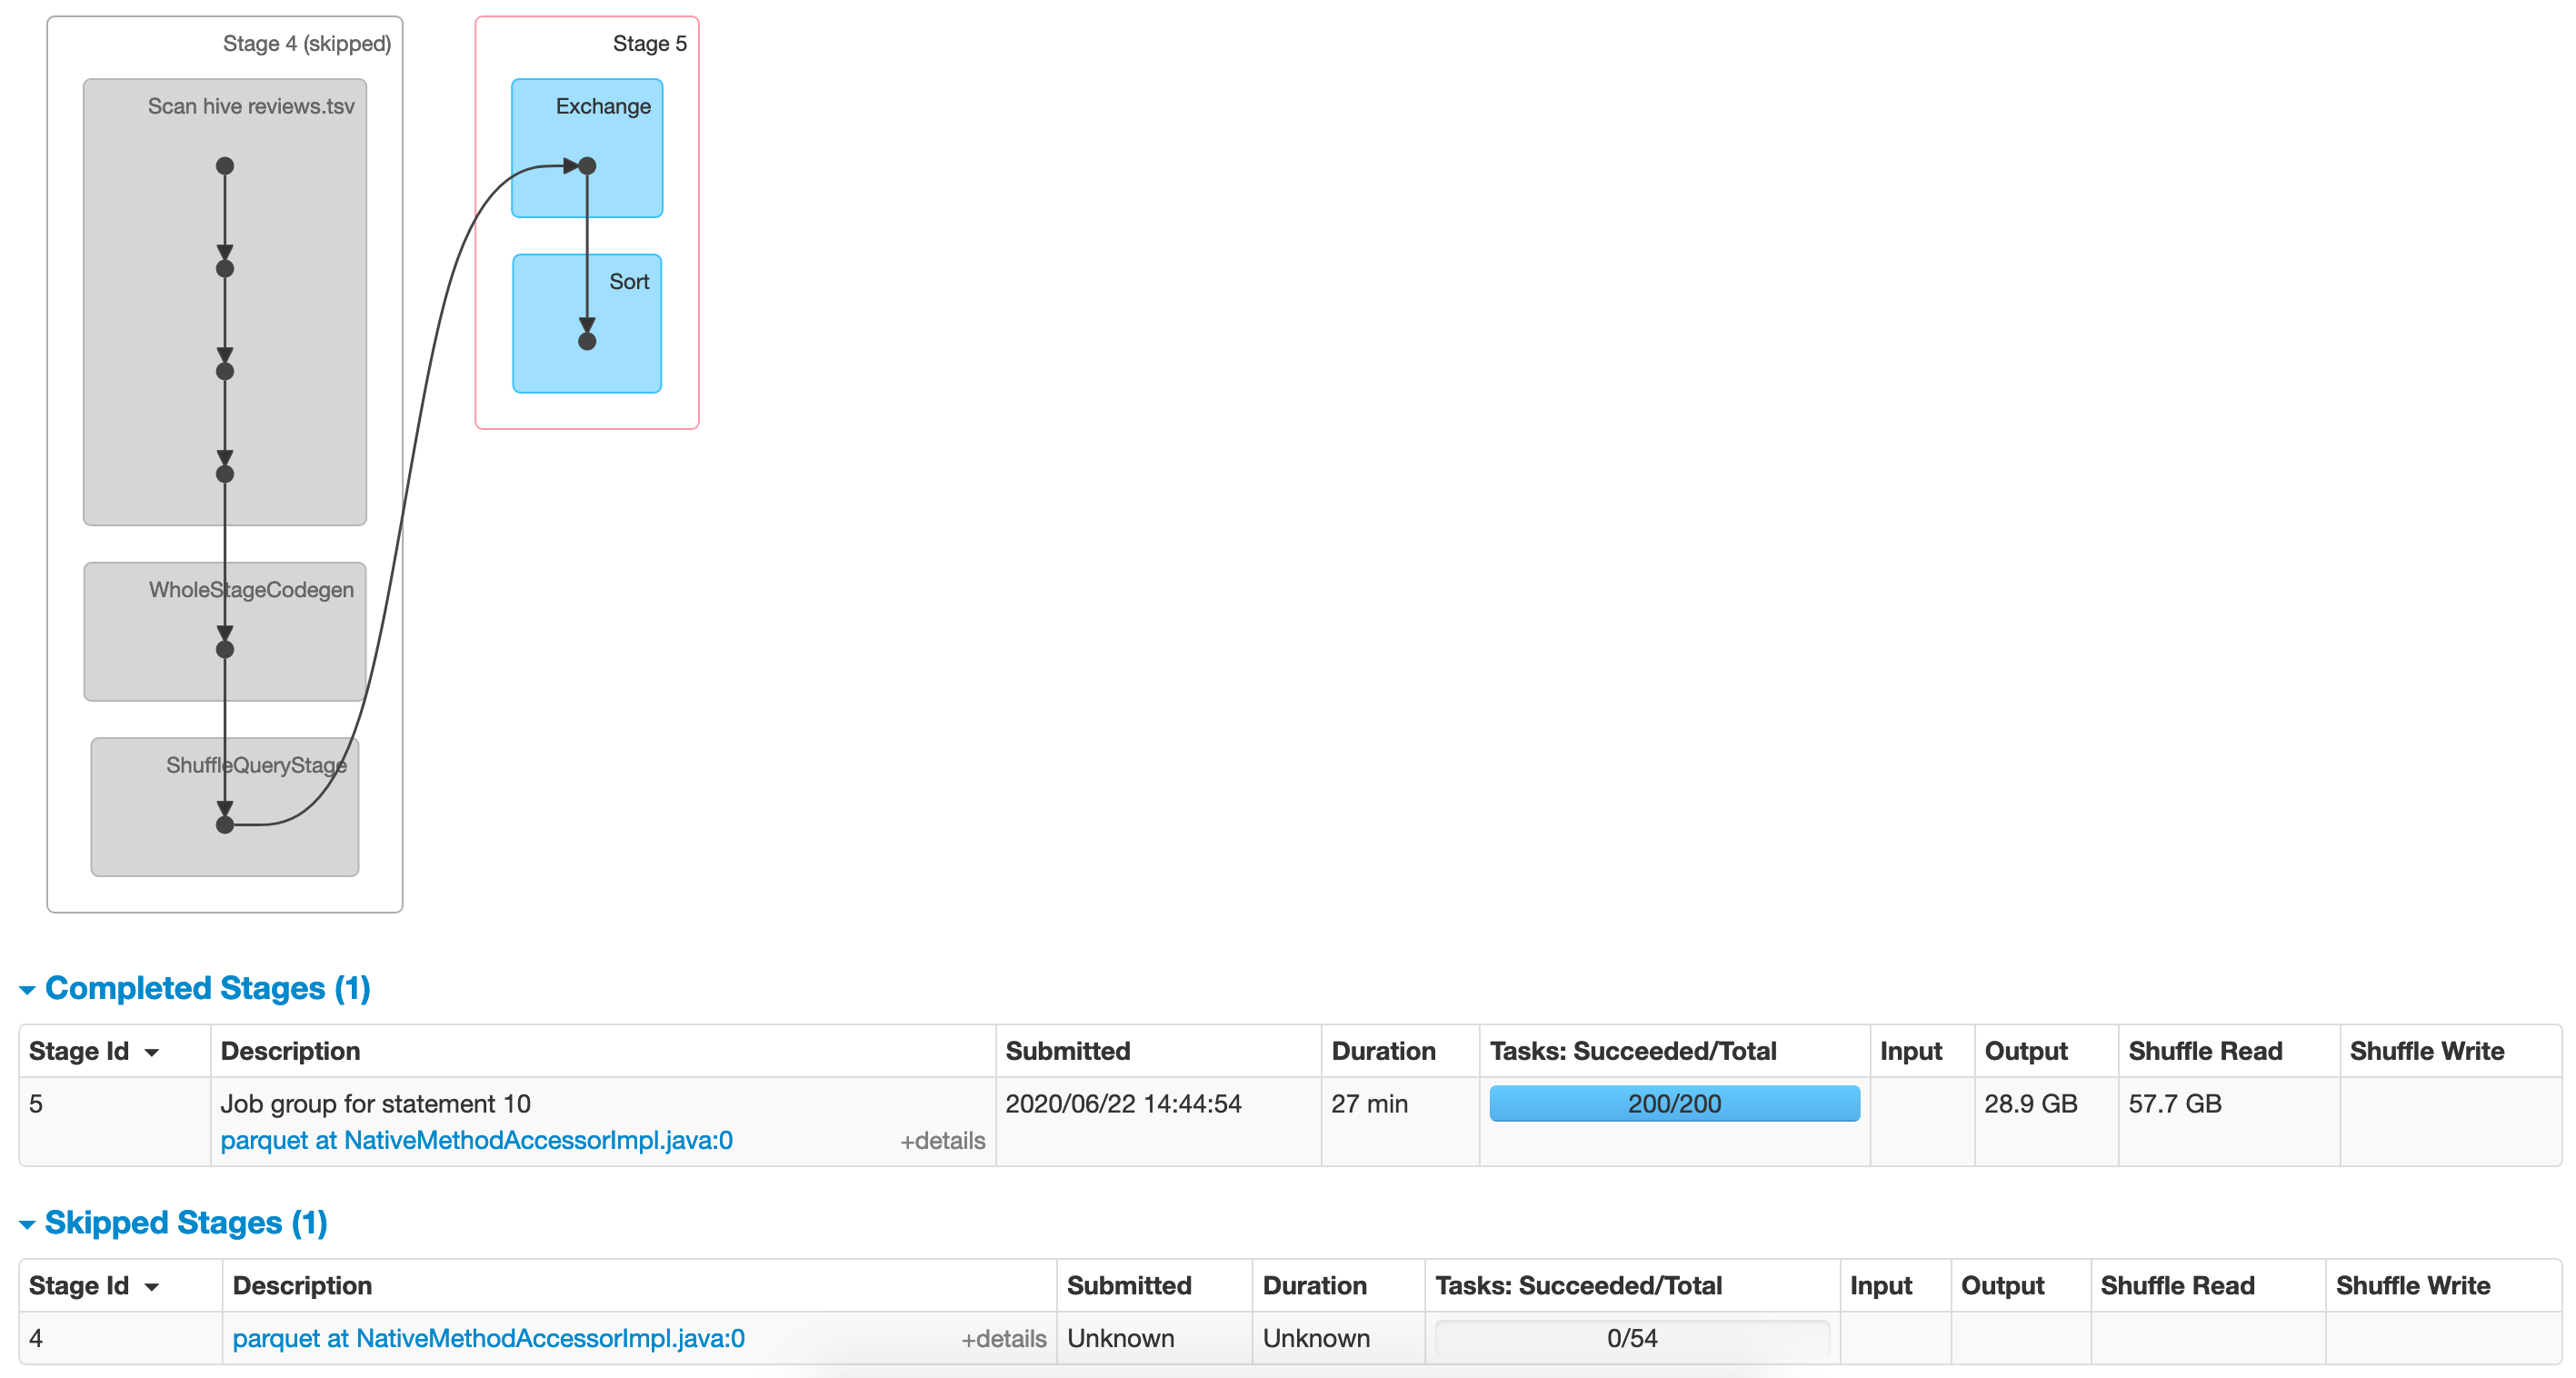

The Ganglia interface can be accessed by either
* Opening TCP 80 access in the security group, or
* Establish a SSH tunnel and port forward (requires EC2 key pair during provisioning)

![ganglia.png](images/ganglia.png)
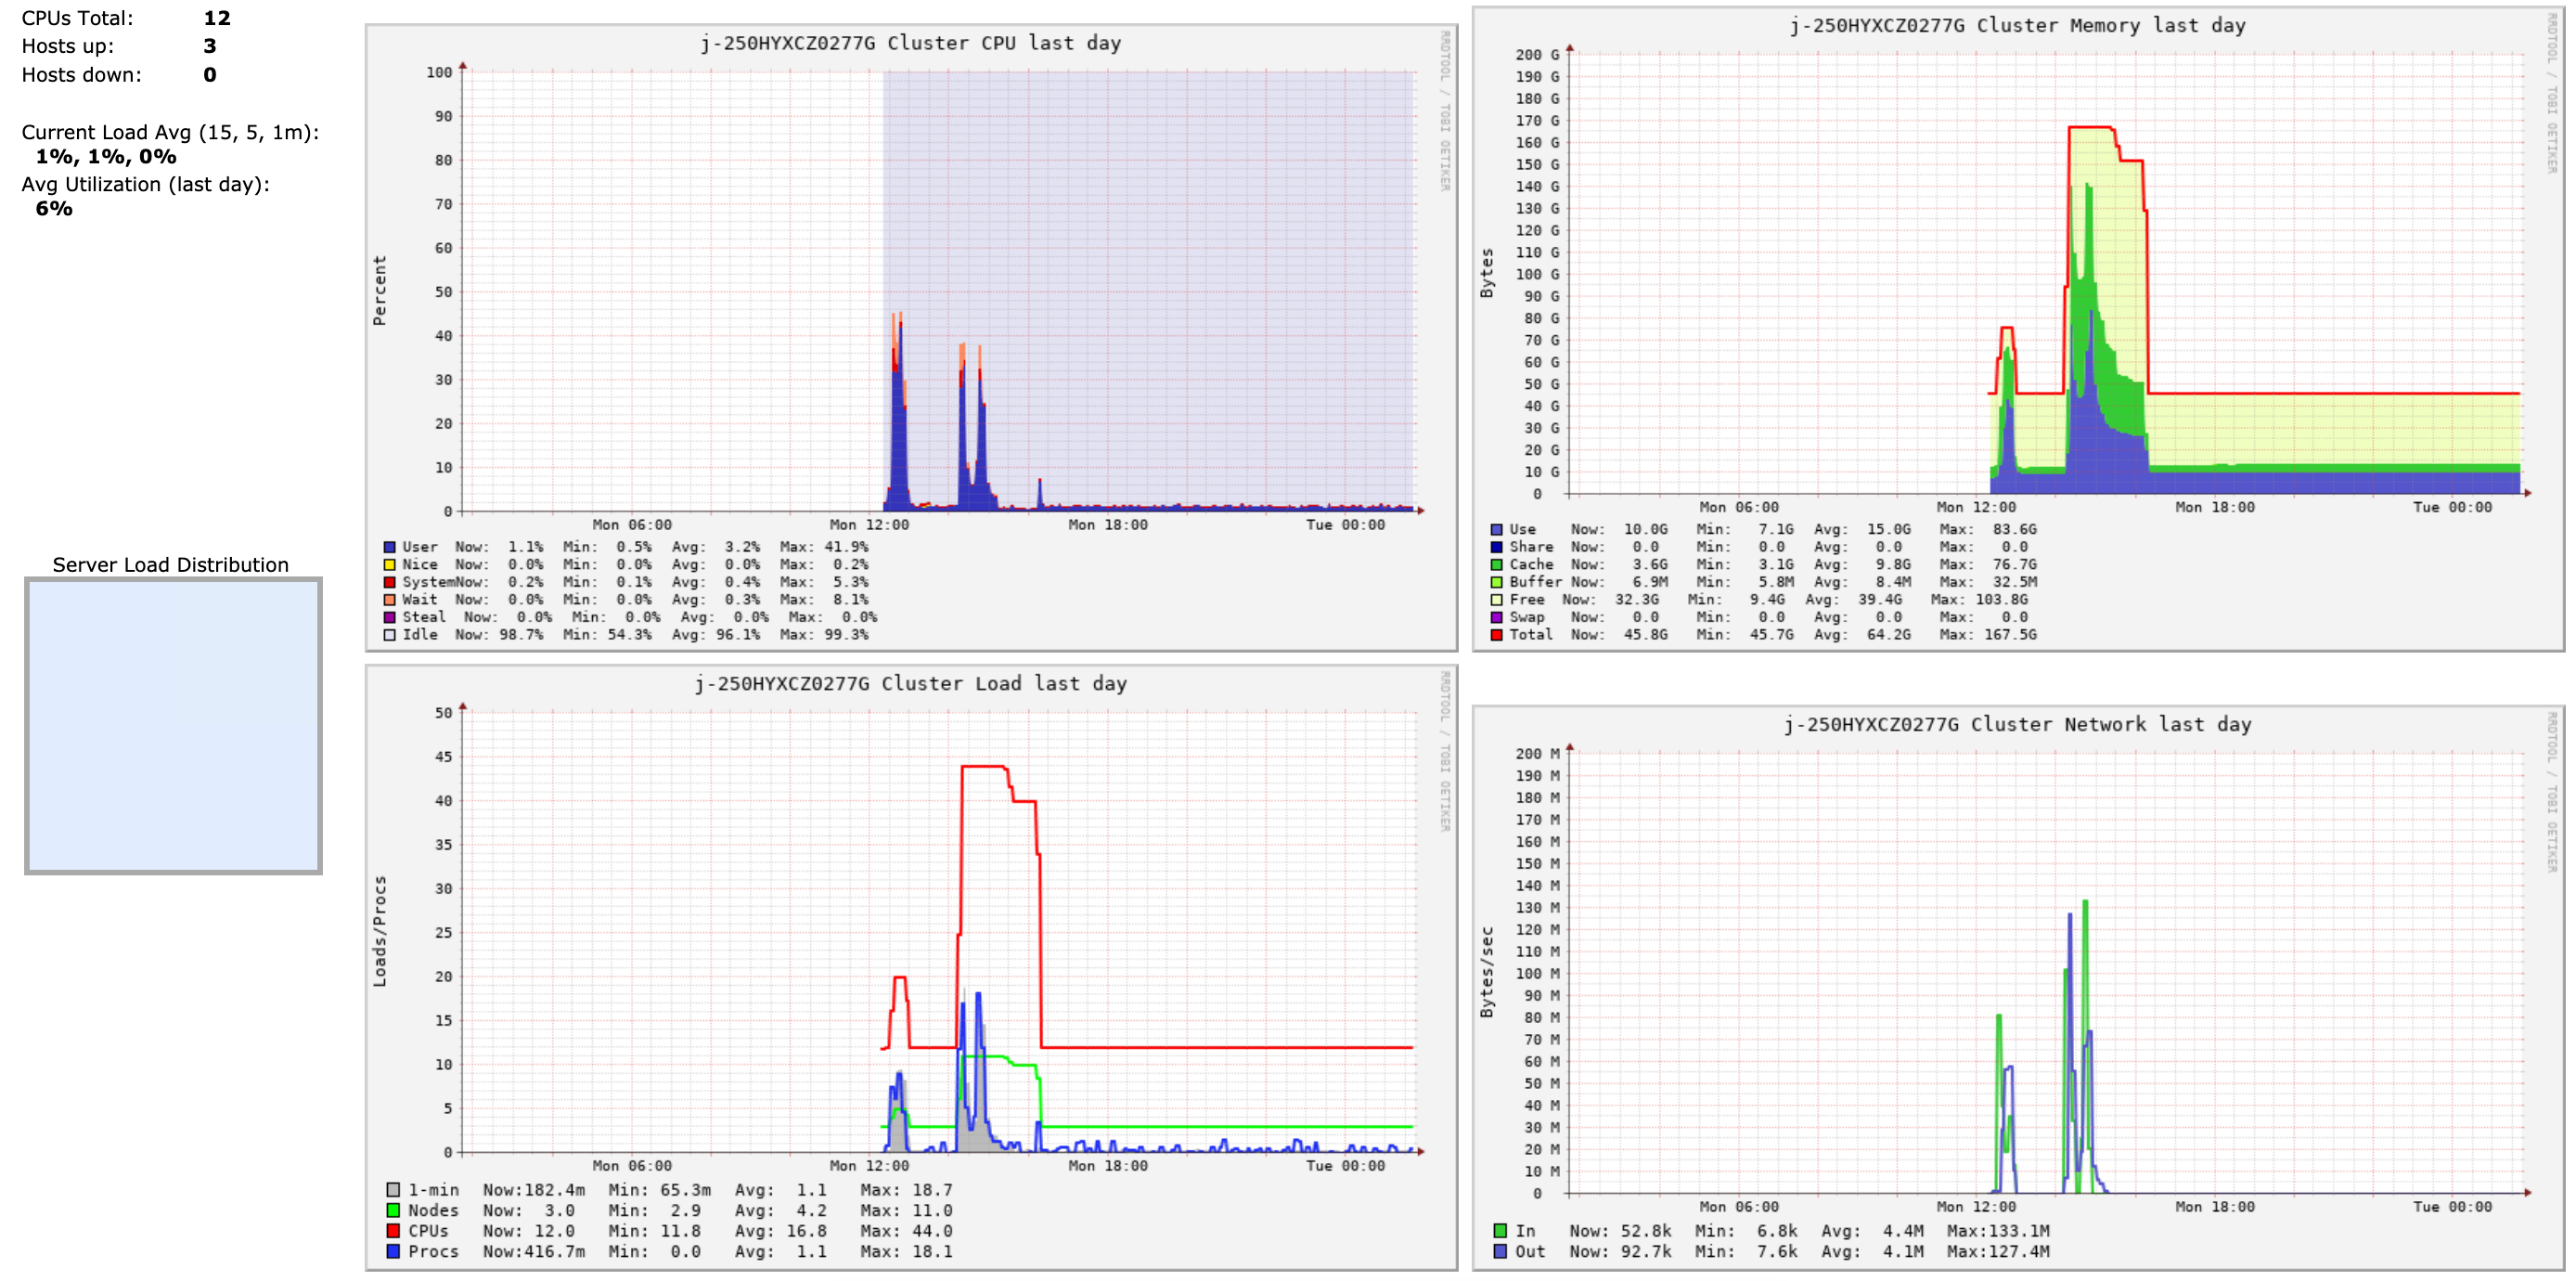